# 1. Getting Data From API

In [94]:
%load_ext autoreload
%autoreload 2
import requests
import pandas as pd
from config import settings
import data
import sqlite3
import matplotlib.pyplot as plt
from model import GarchModel
import plotly.graph_objects as go # type: ignore
import numpy as np # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore
from arch import arch_model # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
use_new_data = False
ticker = 'FPT.VN'
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = data.SQLRepository(connection = connection)
if use_new_data:
    # Instantiate API
    api = data.EodhdAPI()
    new_data = api.get_daily(ticker)
    # Insert data into repo
    repo.insert_table(table_name = ticker, records = new_data, if_exists = 'replace')
df = repo.read_table(table_name = ticker, limit = None)

# Exploratory Data Analysis (EDA)

In [23]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close)])
fig.update_layout(xaxis_rangeslider_visible=False,
                  yaxis_title="Price (VND)",
                  title_text = f"Candlestick chart of {ticker} from {df.index[0].strftime('%Y/%m/%d')} to {df.index[-1].strftime('%Y/%m/%d')}",
                  title_x=0.5,
                  font=dict(size=18,color="Black")
                  )
fig.show()

- [Event in 2023-07-05](https://s.cafef.vn/fpt-1776694/niem-vui-nhan-doi-voi-co-dong-fpt-co-phieu-vuot-dinh-dung-ngay-lan-chot-co-tuc.chn):
  - In early July, FPT also disbursed VND 1,100 billion to pay the remaining dividend for 2022 to shareholders at a rate of 10% in cash. In addition, the company also issued 165.6 million shares to pay the dividend for 2022 at a ratio of 20:3. As a result, the charter capital after the issuance increased from VND 11,000 billion to VND 12,700 billion.
- This explain the reason of the gap in the price of FPT on 2023-07-05
- Therefore, for simplicity, we will focus on the data after 2023-07-05 
- Note: because [EodhdAPI](https://eodhd.com/) only provide the one-year data, readers might not reproduce the result in the future.

In [104]:
def wrangle(df):
    df['return'] = df['close'].pct_change() * 100
    df.dropna(inplace=True)
    df = df.loc['2023-07-06':]
    return df

In [105]:
df_wrangle = wrangle(df)
df_wrangle.head()

,open,high,low,close,adjusted_close,volume,returns,return
date,,,,,,,,
2023-07-06,74800,75200,74000,74600,73737.5723,1520000,-0.267380,-0.267380
2023-07-07,74200,75500,74200,75300,74429.4798,896300,0.938338,0.938338
2023-07-10,75300,75900,74900,75300,74429.4798,1150000,0.000000,0.000000
2023-07-11,75300,75400,75000,75000,74132.9480,1090000,-0.398406,-0.398406
2023-07-12,75000,75700,74900,75300,74429.4798,904900,0.400000,0.400000


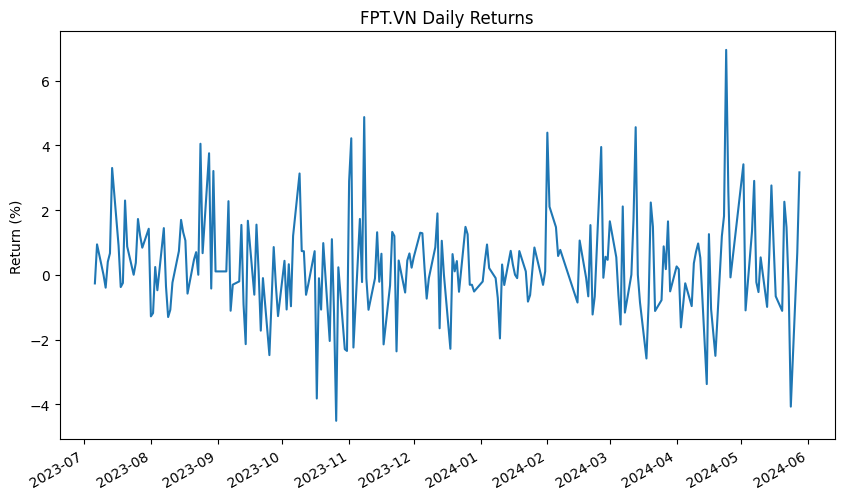

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df_wrangle['return'].plot(ax = ax)
ax.set_title(f'{ticker} Daily Returns')
ax.set_ylabel('Return (%)')
ax.set_xlabel('');

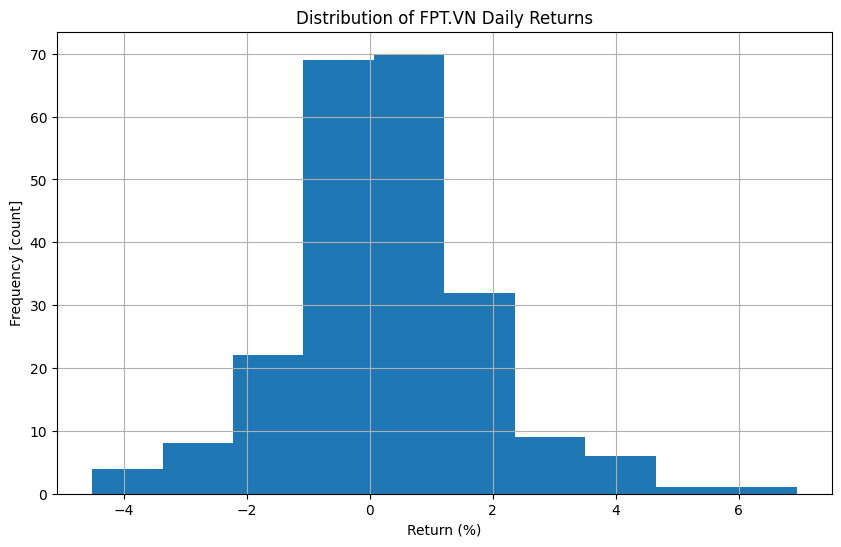

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df_wrangle['return'].hist(ax = ax)
ax.set_title(f'Distribution of {ticker} Daily Returns')
ax.set_ylabel('Frequency [count]')
ax.set_xlabel('Return (%)');

This is a familiar shape! It turns out that returns follow an almost normal distribution, centered on `0`. **Volatility** is the measure of the spread of these returns around the mean. In other words, volatility in finance is the same thing at standard deviation in statistics.

Let's start by measuring the daily volatility of our two stocks. Since our data frequency is also daily, this will be exactly the same as calculating the standard deviation.

In [108]:
FPT_daily_volatility = df_wrangle['return'].std()

print(f"{ticker} Daily Volatility:", round(FPT_daily_volatility,4))

FPT.VN Daily Volatility: 1.5607


- While daily volatility is useful, investors are also interested in volatility over other time periods — like annual volatility. Keep in mind that a year isn't 365 days for a stock market, though. After excluding weekends and holidays, most markets have only 252 trading days.
- And because we only consider the data after 2023-07-06, there are only 222 trading days in our data.

In [109]:
FPT_annual_volatility = FPT_daily_volatility * np.sqrt(len(df_wrangle))

print(f"{ticker} Daily Volatility:", round(FPT_annual_volatility,4))

FPT.VN Daily Volatility: 23.2541


- Since we're dealing with time series data, another way to look at volatility is by calculating it using a rolling window. 
- Calculate the rolling volatility for `return`, using a 5-day window. Assign the result to `FPT_rolling_5d_volatility`.

In [110]:
FPT_rolling_5d_volatility = df_wrangle['return'].rolling(window = 5).std().dropna()

print("rolling_5d_volatility type:", type(FPT_rolling_5d_volatility))
print("rolling_5d_volatility shape:", FPT_rolling_5d_volatility.shape)
FPT_rolling_5d_volatility.head()

rolling_5d_volatility type: <class 'pandas.core.series.Series'>
rolling_5d_volatility shape: (218,)


date
2023-07-12    0.543192
2023-07-13    0.530469
2023-07-14    1.457324
2023-07-17    1.388986
2023-07-18    1.384402
Name: return, dtype: float64

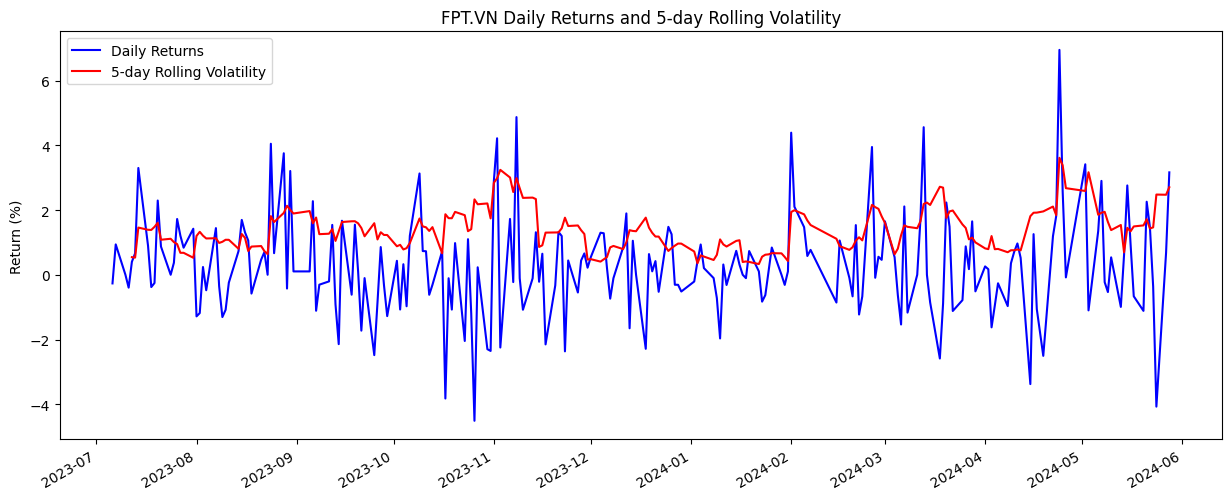

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot `return`
df_wrangle['return'].plot(ax = ax, color = 'blue', label = 'Daily Returns')
# Plot `FPT_rolling_50d_volatility`
FPT_rolling_5d_volatility.plot(ax = ax, color = 'red', label = '5-day Rolling Volatility')
# Add x-axis label
ax.set_xlabel('')
ax.set_ylabel('Return (%)')
# Add title
ax.set_title(f'{ticker} Daily Returns and 5-day Rolling Volatility')
# Add legend
ax.legend();

- Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2024, when there were several days of large negative returns. We can also see volatility go down in April 2024, when there are only small day-to-day changes in returns.

- This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values. 

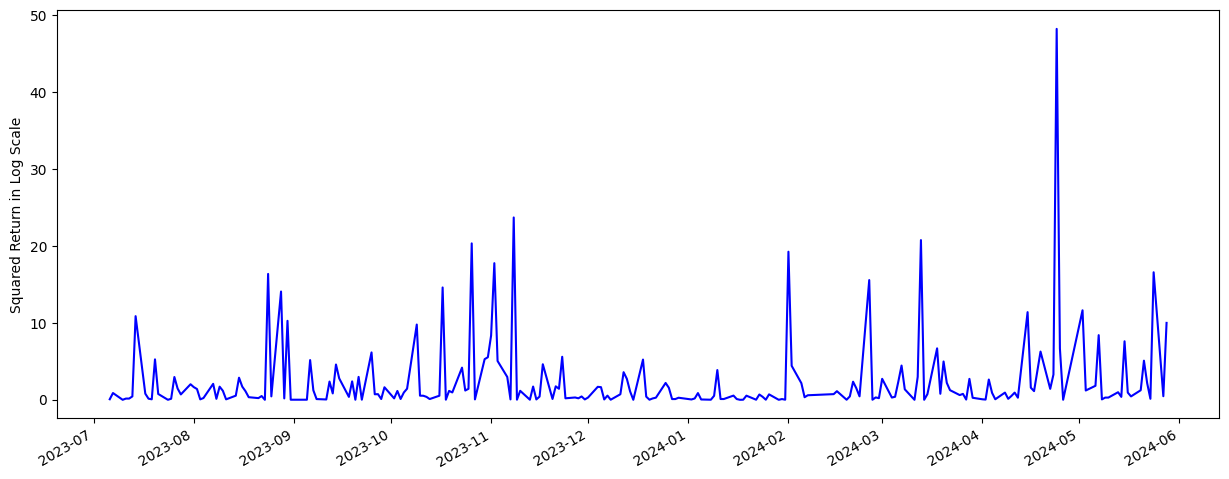

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot squared returns
(df_wrangle['return']**2).plot(ax = ax, color = 'blue', label = 'Daily Returns')

# Add axis labels
ax.set_xlabel('')
ax.set_ylabel('Squared Return in Log Scale');
# ax.set_yscale('log');

Perfect! Now it's much easier to see that (1) we have periods of high and low volatility, and (2) high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

A GARCH model is sort of like the ARMA model. It has a `p` parameter handling correlations at prior time steps and a `q` parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an ACF and PACF plot — but using the squared returns. 

- Create an ACF plot of squared returns for FPT. 

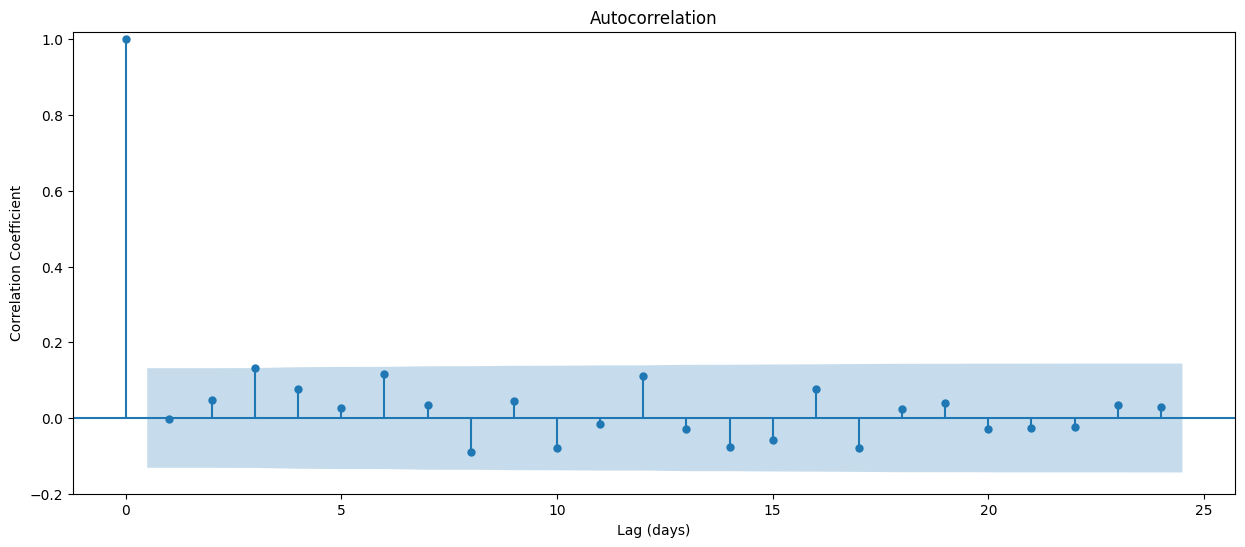

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create ACF of squared returns
plot_acf(df_wrangle['return']**2,ax = ax)

# Add axis labels
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation Coefficient');
ax.set_ylim(-0.2, 1.02);

Create an PACF plot of squared returns for FPT. 

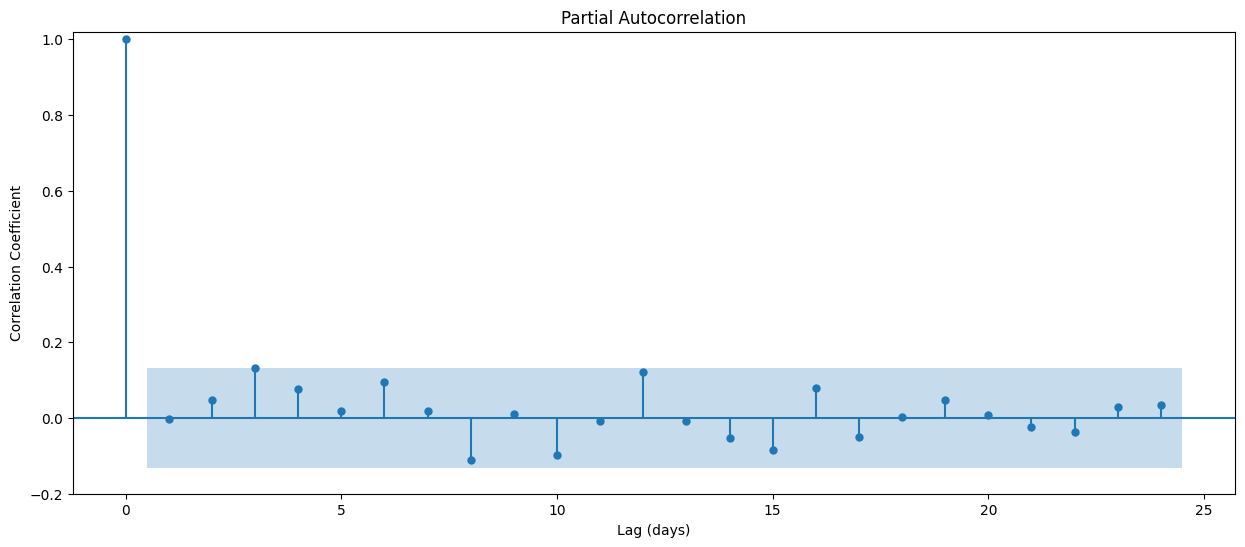

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create PACF of squared returns
plot_pacf(df_wrangle['return']**2,ax = ax)

# Add axis labels
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation Coefficient');
ax.set_ylim(-0.2, 1.02);

In our PACF, it looks like a lag of 1 would be a good starting point. 

Normally, at this point in the model building process, we would split our data into training and test sets, and then set a baseline. Not this time. This is because our model's input and its output are two different measurements. We'll use **returns** to train our model, but we want it to predict **volatility**. If we created a test set, it wouldn't give us the "true values" that we'd need to assess our model's performance. So this time, we'll skip right to iterating. 

# Split

The last thing we need to do before building our model is to create a training set. Note that we won't create a test set here. Rather, we'll use all of `df['return']` to conduct walk-forward validation after we've built our model. 

In [116]:
cutoff_test = 0.8
y_FPT_train = df_wrangle['return'].iloc[: int(cutoff_test * len(df_wrangle))]

print("y_FPT_train type:", type(y_FPT_train))
print("y_FPT_train shape:", y_FPT_train.shape)
y_FPT_train.head()

y_FPT_train type: <class 'pandas.core.series.Series'>
y_FPT_train shape: (177,)


date
2023-07-06   -0.267380
2023-07-07    0.938338
2023-07-10    0.000000
2023-07-11   -0.398406
2023-07-12    0.400000
Name: return, dtype: float64

# Build Model

In [119]:
model = arch_model(
    y_FPT_train,
    p = 3,
    q = 3,
    rescale = False
).fit(disp = 0)
print("model type:", type(model))
# Display model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -314.601
Distribution:                  Normal   AIC:                           645.203
Method:            Maximum Likelihood   BIC:                           670.612
                                        No. Observations:                  177
Date:                Thu, May 30 2024   Df Residuals:                      176
Time:                        17:33:04   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2843      0.114      2.500  1.244e-02 [6.136e-02,  0.507]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.4113      0.850      0.484      0.629    [ -1.255,  2.078]
alpha[1]       0.0000      0.159      0.000      1.000    [ -0.312,  0.312]
alpha[2]       0.0884  8.048e-02      1.099      0.272 [-6.931e-02,  0.246]
alpha[3]       0.0338      0.291      0.116      0.908    [ -0.538,  0.605]
beta[1]        0.1841      2.496  7.376e-02      0.941    [ -4.708,  5.076]
beta[2]        0.5073      1.260      0.403      0.687    [ -1.961,  2.976]
beta[3]        0.0000      0.743      0.000      1.000    [ -1.456,  1.456]
===========================================================================

Covariance estimator: robust
"""

Create a time series plot with the FPT returns and the conditional volatility for your `model`. Be sure to include axis labels and add a legend.

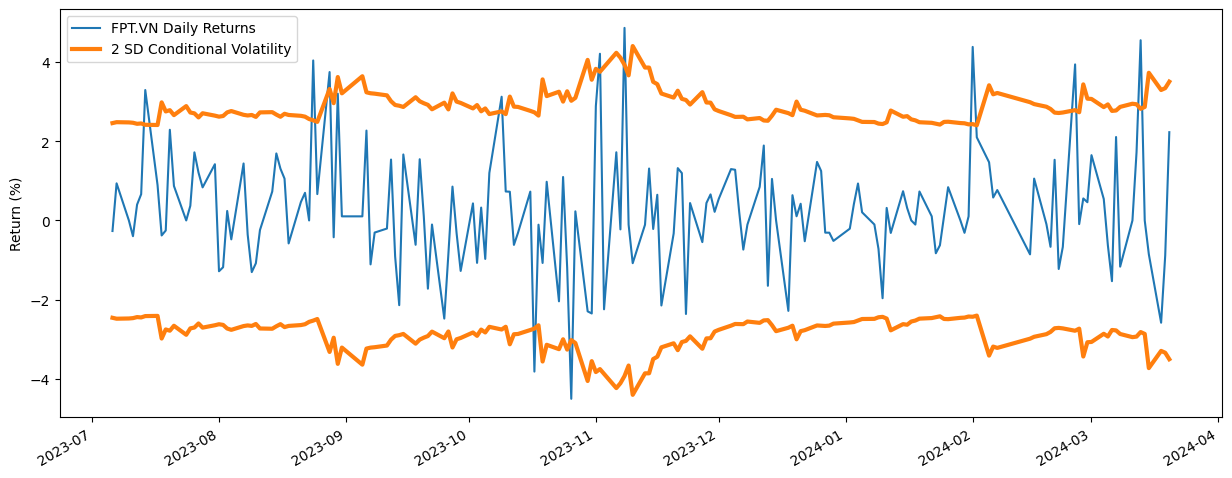

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot `y_FPT_train`
y_FPT_train.plot(ax = ax, label = f'{ticker} Daily Returns')

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(ax = ax, color = 'C1', label = '2 SD Conditional Volatility', linewidth =3)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename('')).plot(ax = ax, color = 'C1', linewidth =3)

# Add axis labels
ax.set_xlabel('')
ax.set_ylabel('Return (%)')

# Add legend
ax.legend();


Our model looks pretty good, but we should examine residuals, just to make sure. In the case of GARCH models, we need to look at the standardized residuals. 

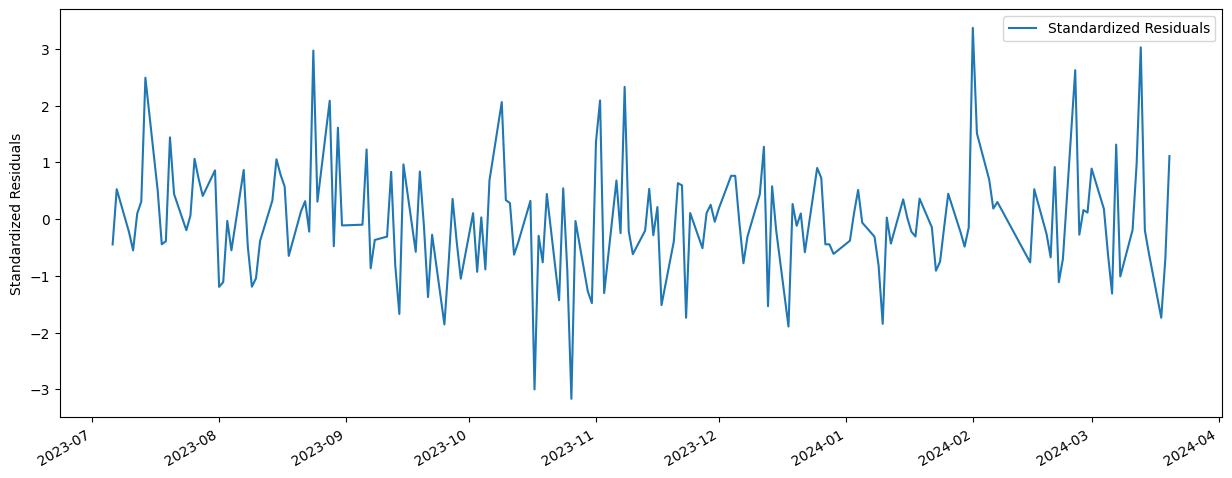

In [122]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot standardized residuals
model.std_resid.plot(ax = ax, label = 'Standardized Residuals')

# Add axis labels
ax.set_xlabel('')
ax.set_ylabel('Standardized Residuals')

# Add legend
ax.legend();

These residuals look good: they have a consistent mean and spread over time. Let's check their normality using a histogram. 

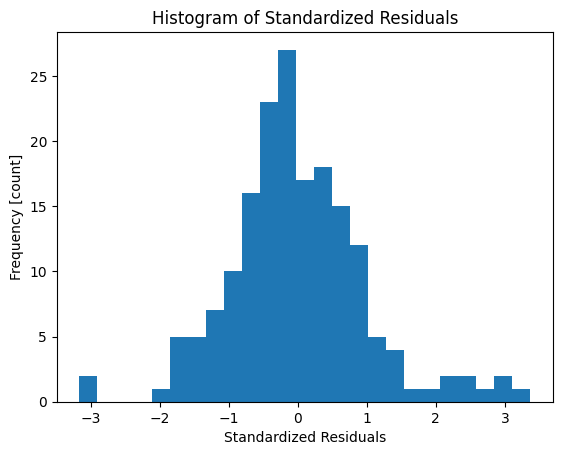

In [124]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins = 25)

# Add axis labels
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency [count]')

# Add title
plt.title('Histogram of Standardized Residuals');

Our last visualization will the ACF of standardized residuals. Just like we did with our first ACF, we'll need to square the values here, too. 

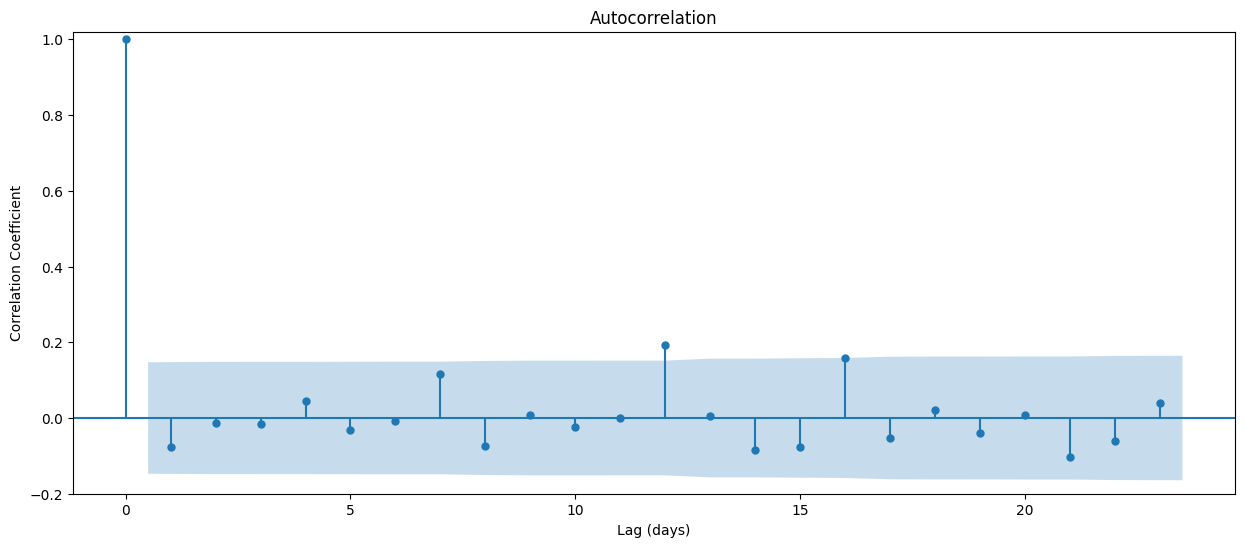

In [126]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax = ax)

# Add axis labels
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation Coefficient')
ax.set_ylim(-0.2, 1.02);

# Evaluate Model

To evaluate our model, we'll do walk-forward validation. Before we do, let's take a look at how this model returns its predictions.

In [131]:
one_day_forecast = model.forecast(horizon = 1, reindex = False).variance

print("one_day_forecast type:", type(one_day_forecast))
print(one_day_forecast)
print(one_day_forecast.iloc[0,0] ** 0.5)

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>
                 h.1
date                
2024-03-20  2.796906
1.6723952470700125


There are two things we need to keep in mind here. First, our `model` forecast shows the predicted **variance**, not the **standard deviation** / **volatility**. So we'll need to take the square root of the value. Second, the prediction is in the form of a DataFrame. It has a DatetimeIndex, and the date is the last day for which we have training data. The `"h.1"` column stands for "horizon 1", that is, our model's prediction for the following day. We'll have to keep all this in mind when we reformat this prediction to serve to the end user of our application.

Complete the code below to do walk-forward validation on your `model`. Then run the following code block to visualize the model's test predictions.

In [137]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(df_wrangle['return']) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = df_wrangle['return'].iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p = 1, q= 1, rescale = False).fit(disp = 0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=df_wrangle['return'].tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (44,)


date
2024-03-22    1.610189
2024-03-25    1.590017
2024-03-26    1.558099
2024-03-27    1.517938
2024-03-28    1.475765
dtype: float64

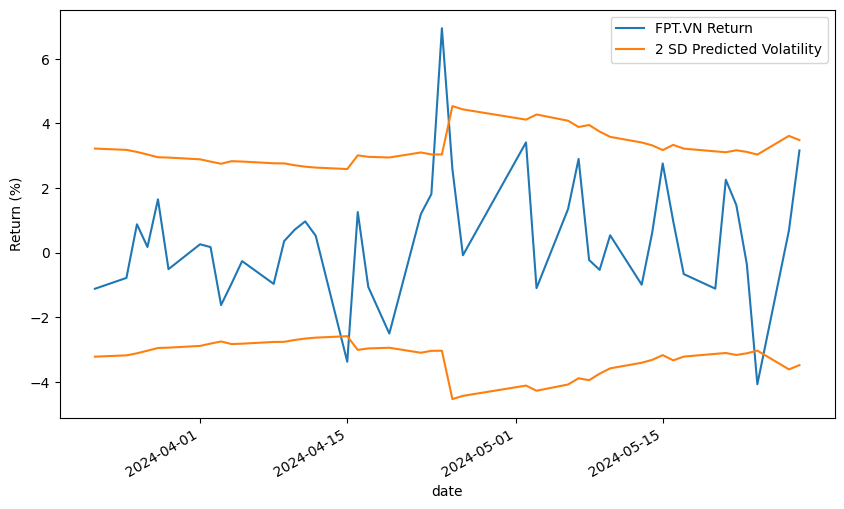

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot returns for test data
df_wrangle['return'].tail(test_size).plot(ax=ax, label=f"{ticker} Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
ax.set_ylabel("Return (%)")

# Add legend
plt.legend();

# API Design and Model Deployment

Go to the command line, navigate to the directory for this project, and start your app server by entering the following command.

```bash
uvicorn my_api:app --reload --workers 1 --host localhost --port 8008
```

In [46]:
url = "http://localhost:8008/hello"
response = requests.get(url = url)

print("response code:", response.status_code)
response.json()

response code: 200


{'message': 'Hello world!'}

In [49]:
# URL of '/fit' path
url = "http://localhost:8008/fit"

# Data to send to path
json = {
    "ticker": "FPT.VN",
    "use_new_data": False,
    "n_observations" : 200,
    "p": 1,
    "q" : 1
}

# Response of post request
response = requests.post(url = url, json = json)

# Inspect response
print("response code:", response.status_code)
response.json()

response code: 200


{'ticker': 'FPT.VNNNNN',
 'use_new_data': True,
 'n_observations': 200,
 'p': 1,
 'q': 1,
 'success': False,
 'message': 'Expecting value: line 1 column 1 (char 0)'}

In [53]:
# URL of `/predict` path
url = "http://localhost:8008/predict"
# Data to send to path
json = {'ticker':'FPT.VN', 'n_days': 5}
# Response of post request
response = requests.post(url = url, json = json)
# Response JSON to be submitted to grader
prediction = response.json()
# Inspect JSON
prediction

{'ticker': 'FPT.VN',
 'n_days': 5,
 'success': True,
 'forecast': {'2024-03-15T00:00:00': 1.2582860041070854,
  '2024-03-18T00:00:00': 1.2547396314184365,
  '2024-03-19T00:00:00': 1.2512236304315763,
  '2024-03-20T00:00:00': 1.2477377978019735,
  '2024-03-21T00:00:00': 1.2442819309389883},
 'message': ''}